In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/analytics-industry-salaries-2022-india/info.txt
/kaggle/input/analytics-industry-salaries-2022-india/Salary Dataset.csv


# Preparation

In [2]:
import sklearn as sk
import matplotlib.pyplot as pyplot
import seaborn as sb
import re
import matplotlib as mpl

## Loading files

In [3]:
source_dt = pd.read_csv('/kaggle/input/analytics-industry-salaries-2022-india/Salary Dataset.csv',header=0)

In [4]:
source_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4344 entries, 0 to 4343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Company Name       4341 non-null   object 
 1   Job Title          4344 non-null   object 
 2   Salaries Reported  4342 non-null   float64
 3   Location           4344 non-null   object 
 4   Salary             4344 non-null   object 
dtypes: float64(1), object(4)
memory usage: 169.8+ KB


As we can see, its a very good dataset with no null values. The ideal next step would have been to take care of null values, but that is not needed here. Lets have a look at some samples.

In [5]:
source_dt.dtypes

Company Name          object
Job Title             object
Salaries Reported    float64
Location              object
Salary                object
dtype: object

In [6]:
source_dt.head(10)

,Company Name,Job Title,Salaries Reported,Location,Salary
0,Mu Sigma,Data Scientist,105.0,Bangalore,"₹6,48,573/yr"
1,IBM,Data Scientist,95.0,Bangalore,"₹11,91,950/yr"
2,Tata Consultancy Services,Data Scientist,66.0,Bangalore,"₹8,36,874/yr"
3,Impact Analytics,Data Scientist,40.0,Bangalore,"₹6,69,578/yr"
4,Accenture,Data Scientist,32.0,Bangalore,"₹9,44,110/yr"
5,Infosys,Data Scientist,30.0,Bangalore,"₹9,08,764/yr"
6,Capgemini,Data Scientist,28.0,Bangalore,"₹9,26,124/yr"
7,Cognizant Technology Solutions,Data Scientist,26.0,Bangalore,"₹7,36,708/yr"
8,Anheuser-Busch InBev,Data Scientist,25.0,Bangalore,"₹16,46,721/yr"
9,Fractal,Data Scientist,22.0,Bangalore,"₹13,92,960/yr"


The last field , Salary, is not in a good format for analysis. It contains string characters and the salary time frames are not uniform (monthly/ hourly/ annual are all mixed). Lets create a numerical only annual data field.

In [7]:
source_dt['Salary'] = source_dt['Salary'].astype("string")
source_dt['Company Name'] = source_dt['Company Name'].astype("string")
source_dt['Job Title'] = source_dt['Job Title'].astype("string")
source_dt['Location'] = source_dt['Location'].astype("string")


In [8]:
temp_arr = []
for itr in source_dt['Salary']:
    tmp_chr = ''
    for in_itr in itr:
        if in_itr.isdigit():
            tmp_chr +=in_itr
        
    temp_arr.append(tmp_chr)
source_dt['Salary Value'] = temp_arr       
source_dt['Salary Value'] = source_dt['Salary Value'].astype(int)
multipliers = []
for itr in source_dt['Salary']:
    if itr.find('yr') != -1:
        multipliers.append(1)
    elif itr.find('hr') != -1:
        multipliers.append(2088) # Assuming 8 hours a day. removing weekends. still this will be an over estimate as we cant account for holidays
    elif itr.find('mo') != -1:
        multipliers.append(12)
    else:
        multipliers.append(-1)
source_dt['Multipliers'] = multipliers
source_dt['Salary Value'] = source_dt['Salary Value']*source_dt['Multipliers']
#df['Numbers Only'] = df['Numbers and Text'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)

In [9]:
source_dt = source_dt[source_dt['Multipliers'] > 0]
source_dt.head(100)

,Company Name,Job Title,Salaries Reported,Location,Salary,Salary Value,Multipliers
0,Mu Sigma,Data Scientist,105.0,Bangalore,"₹6,48,573/yr",648573,1
1,IBM,Data Scientist,95.0,Bangalore,"₹11,91,950/yr",1191950,1
2,Tata Consultancy Services,Data Scientist,66.0,Bangalore,"₹8,36,874/yr",836874,1
3,Impact Analytics,Data Scientist,40.0,Bangalore,"₹6,69,578/yr",669578,1
4,Accenture,Data Scientist,32.0,Bangalore,"₹9,44,110/yr",944110,1
...,...,...,...,...,...,...,...
95,IBM,Data Scientist,4.0,Bangalore,"₹32,953/mo",395436,12
96,ascena,Data Scientist,4.0,Bangalore,"₹16,49,930/yr",1649930,1
97,QuantZig,Data Scientist,4.0,Bangalore,"₹11,38,060/yr",1138060,1
98,Baker Hughes,Data Scientist,4.0,Bangalore,"₹16,12,744/yr",1612744,1


Now we can start on some analysis. The Data fields are corrected.

# Analysis

## Role level Pay scale
Lets Start with the simplest thing first, which out of the listed designations pay the most.

Lets have a look at all posible desginations first, including samples for which we only have 1-2 records

In [10]:
temp_dt = source_dt[source_dt['Salaries Reported']>0]
temp_dt['Salary Value'].groupby(temp_dt['Job Title']).mean().round(0)

Job Title
Associate Machine Learning Engineer          464372.0
Data Analyst                                 573652.0
Data Engineer                                907729.0
Data Science                                 364905.0
Data Science Associate                      1203913.0
Data Science Consultant                     2671464.0
Data Science Lead                           4068310.0
Data Science Manager                        4619021.0
Data Scientist                              1135470.0
Data Scientist - Trainee                     610512.0
Junior Data Scientist                        596323.0
Lead Data Scientist                         1852189.0
Machine Learning Associate                   295114.0
Machine Learning Consultant                  706401.0
Machine Learning Data Analyst                361378.0
Machine Learning Data Associate              275841.0
Machine Learning Data Associate I            258596.0
Machine Learning Data Associate II           383213.0
Machine Learning D

Lets Sort it and prepare a chart of the top 5

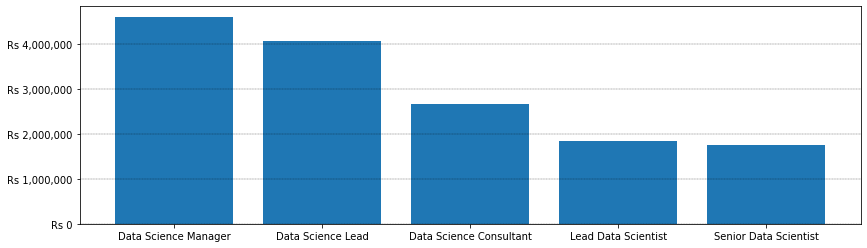

In [11]:
chart_dt = temp_dt['Salary Value'].groupby(temp_dt['Job Title']).mean().round(0)
chart_dt = chart_dt.sort_values(ascending = False)
chart_dt = chart_dt.head(5)

fig,ax = pyplot.subplots(figsize = (14,4))

ax.bar(chart_dt.index,chart_dt.values)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('Rs {x:,.0f}'))
ax.yaxis.grid(color='black', linestyle='--', linewidth= 0.3)
pyplot.show()

This might not be very useful however, as the count of some desgination can be very low. To get a good result, we must remove those categories for which we dont have enough samples.

In [12]:
filter_dt = source_dt['Salaries Reported'].groupby(source_dt['Job Title']).sum().round(0)


In [13]:
filter_dt = filter_dt[filter_dt.values > 500]
filter_dt

Job Title
Data Analyst                 4466.0
Data Engineer                2130.0
Data Scientist               4404.0
Machine Learning Engineer     809.0
Name: Salaries Reported, dtype: float64

In [14]:
job_list = filter_dt.index.tolist()
temp_dt_bool = source_dt['Job Title'].isin(job_list)
temp_dt = source_dt[temp_dt_bool]
temp_dt['Salary Value'].groupby(temp_dt['Job Title']).mean().round(0)

Job Title
Data Analyst                  573531.0
Data Engineer                 907729.0
Data Scientist               1135470.0
Machine Learning Engineer     777532.0
Name: Salary Value, dtype: float64

As we can see, only 4 remain when we apply the filter count> 500. Plotting them.

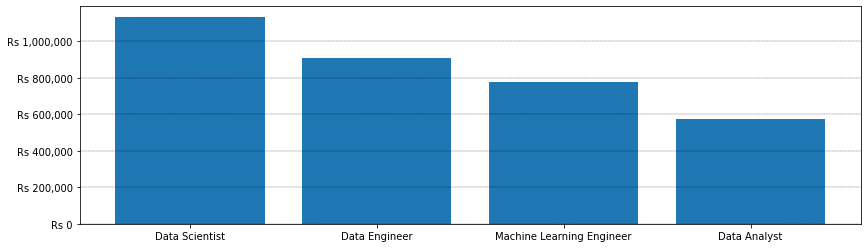

In [15]:
chart_dt = temp_dt['Salary Value'].groupby(temp_dt['Job Title']).mean().round(0)
chart_dt = chart_dt.sort_values(ascending = False)
chart_dt = chart_dt.head(5)

fig,ax = pyplot.subplots(figsize = (14,4))

ax.bar(chart_dt.index,chart_dt.values)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('Rs {x:,.0f}'))
ax.yaxis.grid(color='black', linestyle='--', linewidth= 0.3)
pyplot.show()

### Conclusion for this section
Data scientists win! They tend to have higher salaries than other common data based job titles.
Just for completeness, lets also have a look at the maximums.

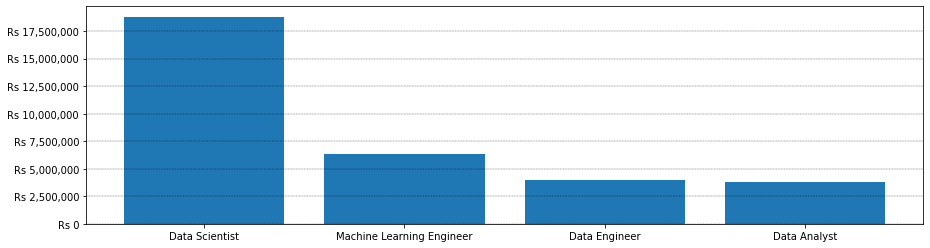

In [16]:

chart_dt = temp_dt['Salary Value'].groupby(temp_dt['Job Title']).max().round(0)
chart_dt = chart_dt.sort_values(ascending = False)
chart_dt = chart_dt.head(5)

fig,ax = pyplot.subplots(figsize = (15,4))

ax.bar(chart_dt.index,chart_dt.values)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('Rs {x:,.0f}'))
ax.yaxis.grid(color='black', linestyle='--', linewidth= 0.3)
pyplot.show()

Those are some hefty salaries.. Lets look at the records.


In [17]:
indexes = source_dt.groupby(['Job Title'])['Salary Value'].transform(max) == source_dt['Salary Value']
Best_salaries = source_dt[indexes]
temp_dt_bool = Best_salaries['Job Title'].isin(job_list)
Best_salaries = Best_salaries[temp_dt_bool]
Best_salaries  

,Company Name,Job Title,Salaries Reported,Location,Salary,Salary Value,Multipliers
900,L Brands,Data Scientist,1.0,Bangalore,"₹15,67,329/mo",18807948,12
2503,Enrich IBS,Data Analyst,1.0,Hyderabad,"₹3,14,473/mo",3773676,12
2517,Nassau Re,Data Analyst,1.0,Hyderabad,"₹3,14,473/mo",3773676,12
3644,Goldman Sachs,Data Engineer,1.0,Mumbai,"₹39,77,066/yr",3977066,1
4062,Meta,Machine Learning Engineer,1.0,Hyderabad,"₹3,017/hr",6299496,2088


## Company data
Now lets see which companies pay the most! We will compare per designation, only for the 4 job titles for which we have sizable data

### Data Scientists

In [18]:
data_scientist_comp_dt = source_dt[source_dt['Job Title'] == "Data Scientist"]
data_scientist_comp_dt_sr_outliers = data_scientist_comp_dt['Salary Value'].groupby(data_scientist_comp_dt['Company Name']).mean().round(0)
data_scientist_comp_dt_sr_outliers = data_scientist_comp_dt_sr_outliers.sort_values(ascending = False)



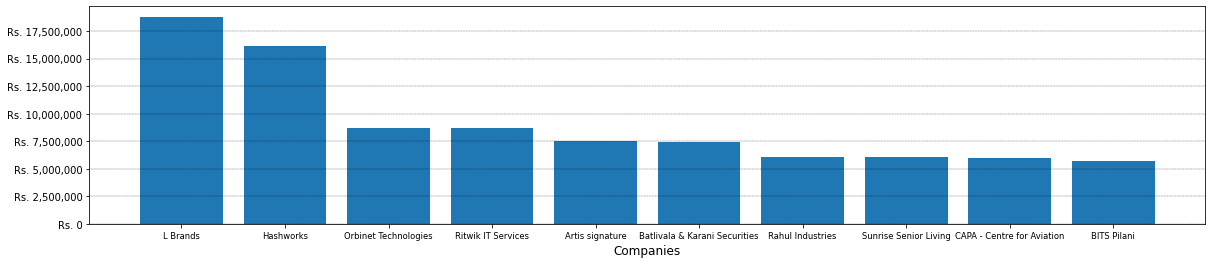

In [19]:
fig,ax = pyplot.subplots(figsize = (20,4))

ax.bar(data_scientist_comp_dt_sr_outliers.head(10).index,data_scientist_comp_dt_sr_outliers.head(10).values)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('Rs. {x:,.0f}'))
ax.yaxis.grid(color='black', linestyle='--', linewidth= 0.3)
ax.xaxis.set_tick_params(labelsize='small')
ax.set_xlabel('Companies',fontsize = 12)
pyplot.show()

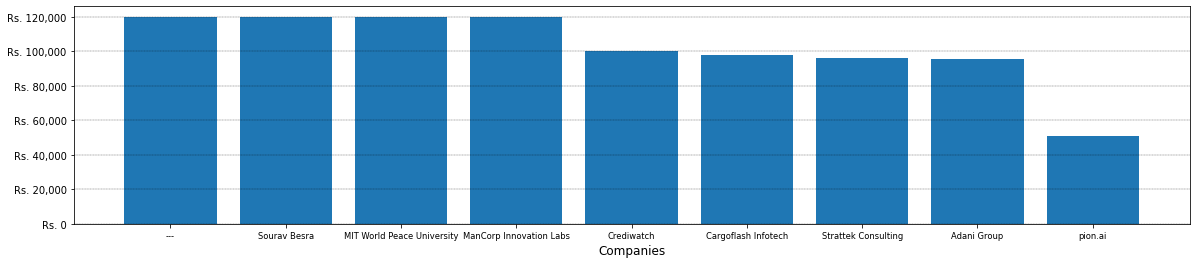

In [20]:
fig,ax = pyplot.subplots(figsize = (20,4))

ax.bar(data_scientist_comp_dt_sr_outliers.tail(9).index,data_scientist_comp_dt_sr_outliers.tail(9).values)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('Rs. {x:,.0f}'))
ax.yaxis.grid(color='black', linestyle='--', linewidth= 0.3)
ax.xaxis.set_tick_params(labelsize='small')
ax.set_xlabel('Companies',fontsize = 12)
pyplot.show()

Same issue as before may happen here as well, a few records with extreme values can skew result. We must look at companies with decent number of samples. For simplicity's sake, lets just go with top 100 companies in terms of reports. 


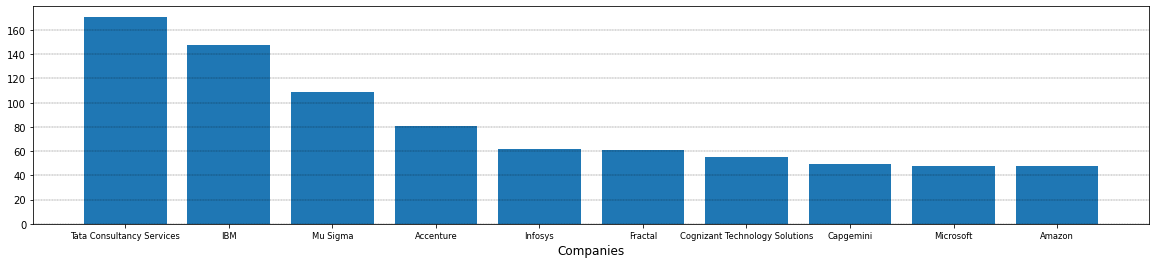

In [21]:
data_scientist_comp_dt_comp_sr = data_scientist_comp_dt['Salaries Reported'].groupby(data_scientist_comp_dt['Company Name']).sum().round(0)
data_scientist_comp_dt_comp_sr = data_scientist_comp_dt_comp_sr.sort_values(ascending = False).head(100)

fig,ax = pyplot.subplots(figsize = (20,4))

ax.bar(data_scientist_comp_dt_comp_sr.head(10).index,data_scientist_comp_dt_comp_sr.head(10).values)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.grid(color='black', linestyle='--', linewidth= 0.3)
ax.xaxis.set_tick_params(labelsize='small')
ax.set_xlabel('Companies',fontsize = 12)
pyplot.show()

Now we can start seeing some big name companies! Lets change our original data to only contain records for these 100 companies

In [22]:
big_companies = data_scientist_comp_dt_comp_sr.index.tolist()
big_companies_bool = data_scientist_comp_dt['Company Name'].isin(big_companies)
data_scientist_comp_dt_no_outliers = data_scientist_comp_dt[big_companies_bool]
data_scientist_comp_dt_no_outliers.head(100)

,Company Name,Job Title,Salaries Reported,Location,Salary,Salary Value,Multipliers
0,Mu Sigma,Data Scientist,105.0,Bangalore,"₹6,48,573/yr",648573,1
1,IBM,Data Scientist,95.0,Bangalore,"₹11,91,950/yr",1191950,1
2,Tata Consultancy Services,Data Scientist,66.0,Bangalore,"₹8,36,874/yr",836874,1
3,Impact Analytics,Data Scientist,40.0,Bangalore,"₹6,69,578/yr",669578,1
4,Accenture,Data Scientist,32.0,Bangalore,"₹9,44,110/yr",944110,1
...,...,...,...,...,...,...,...
459,DONE by NONE,Data Scientist,1.0,Bangalore,"₹51,589/mo",619068,12
466,Happiest Minds Technologies,Data Scientist,1.0,Bangalore,"₹7,82,543/yr",782543,1
469,Fresher,Data Scientist,1.0,Bangalore,"₹50,000/mo",600000,12
491,[24]7.ai,Data Scientist,1.0,Bangalore,"₹85,643/mo",1027716,12


In [23]:
data_scientist_comp_sr_no_outliers = data_scientist_comp_dt_no_outliers['Salary Value'].groupby(data_scientist_comp_dt_no_outliers['Company Name']).mean().round(0)
data_scientist_comp_sr_no_outliers.sort_values(ascending = False).head(10)

Company Name
Société Générale        5719472.0
Walmart                 2567381.0
Flipkart                2567228.0
Ola                     2334960.0
Fidelity Investments    2143501.0
Housing.com             1893532.0
Google                  1857177.0
Wipro Technologies      1812640.0
Adobe                   1784084.0
Axis Bank               1719638.0
Name: Salary Value, dtype: float64

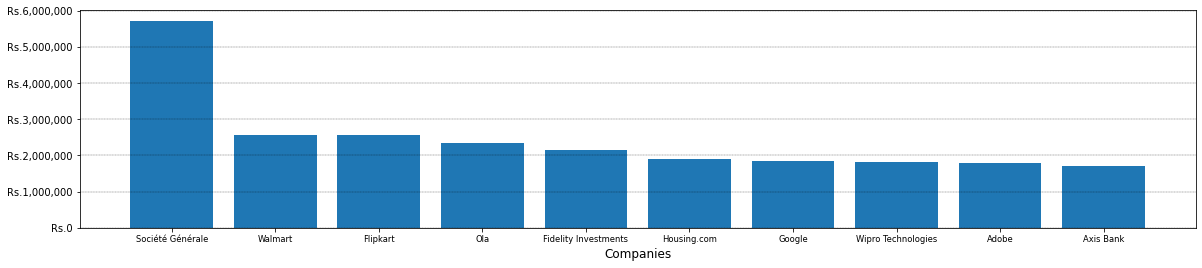

In [24]:
fig,ax = pyplot.subplots(figsize = (20,4))

ax.bar(data_scientist_comp_sr_no_outliers.sort_values(ascending = False).head(10).index,data_scientist_comp_sr_no_outliers.sort_values(ascending = False).head(10).values)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('Rs.{x:,.0f}'))
ax.yaxis.grid(color='black', linestyle='--', linewidth= 0.3)
ax.xaxis.set_tick_params(labelsize='small')
ax.set_xlabel('Companies',fontsize = 12)
pyplot.show()

Now we start seeing some of the big names we were expecting to show up. Lets just have a peek at the wrong end of the table...

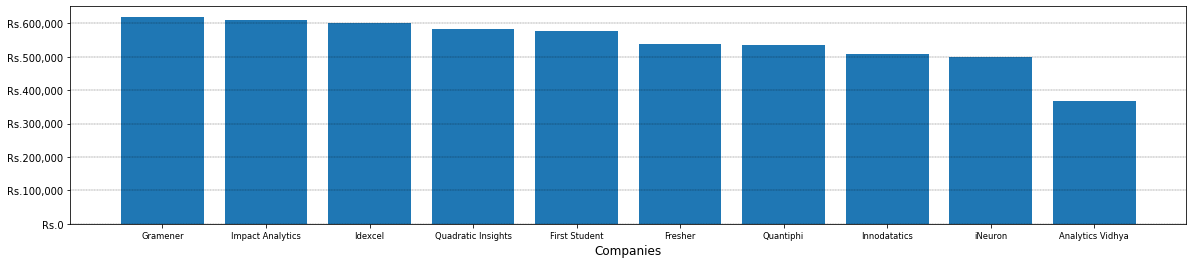

In [25]:
fig,ax = pyplot.subplots(figsize = (20,4))

ax.bar(data_scientist_comp_sr_no_outliers.sort_values(ascending = False).tail(10).index,data_scientist_comp_sr_no_outliers.sort_values(ascending = False).tail(10).values)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('Rs.{x:,.0f}'))
ax.yaxis.grid(color='black', linestyle='--', linewidth= 0.3)
ax.xaxis.set_tick_params(labelsize='small')
ax.set_xlabel('Companies',fontsize = 12)
pyplot.show()

While this difference is not nearly as bad as when we had outliers still in, the salaries here are still almost 10 times lesser than those at the top of the pile. Still, this analysis can be considered as hardly more than a learning exercise, because several factors like employee score, stock performance, NB are not present. Do your research well while looking for a job!

# Data Analytics
The same steps we performed above can be repeated for Data Analytics. We can skip several of the intermediate steps in between and go directly for the final charts.

In [26]:
data_analyst_comp_dt = source_dt[source_dt['Job Title'] == "Data Analyst"]

data_analyst_comp_dt_comp_sr = data_analyst_comp_dt['Salaries Reported'].groupby(data_analyst_comp_dt['Company Name']).sum().round(0)
data_analyst_comp_dt_comp_sr = data_analyst_comp_dt_comp_sr.sort_values(ascending = False).head(100)

big_companies = data_analyst_comp_dt_comp_sr.index.tolist()
big_companies_bool = data_analyst_comp_dt['Company Name'].isin(big_companies)
data_analyst_comp_dt_no_outliers = data_analyst_comp_dt[big_companies_bool]
data_analyst_comp_dt_no_outliers.head(100)


,Company Name,Job Title,Salaries Reported,Location,Salary,Salary Value,Multipliers
1954,Accenture,Data Analyst,62.0,Bangalore,"₹6,08,077/yr",608077,1
1955,Tata Consultancy Services,Data Analyst,48.0,Bangalore,"₹4,83,697/yr",483697,1
1956,Mu Sigma,Data Analyst,45.0,Bangalore,"₹6,10,598/yr",610598,1
1957,Amazon,Data Analyst,44.0,Bangalore,"₹6,70,610/yr",670610,1
1958,Myntra,Data Analyst,41.0,Bangalore,"₹10,04,884/yr",1004884,1
...,...,...,...,...,...,...,...
2202,Wipro,Data Analyst,3.0,Pune,"₹30,000/mo",360000,12
2208,IBM,Data Analyst,3.0,Pune,"₹4,66,187/yr",466187,1
2212,Honeywell,Data Analyst,3.0,Pune,"₹3,62,590/yr",362590,1
2213,First Student,Data Analyst,3.0,Pune,"₹4,03,590/yr",403590,1


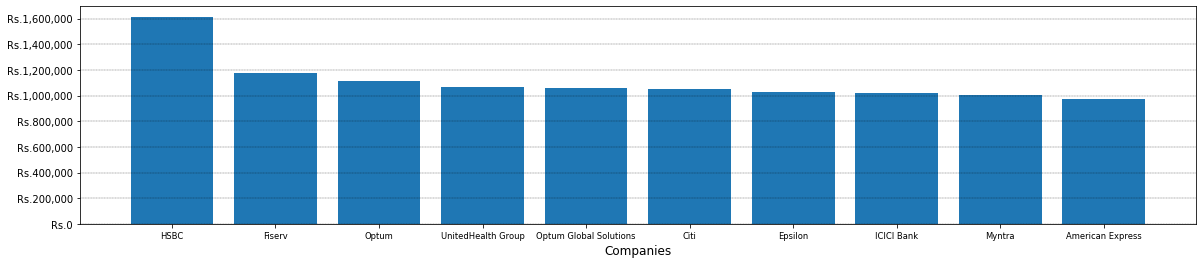

In [27]:
data_analyst_comp_sr_no_outliers = data_analyst_comp_dt_no_outliers['Salary Value'].groupby(data_analyst_comp_dt_no_outliers['Company Name']).mean().round(0)

fig,ax = pyplot.subplots(figsize = (20,4))

ax.bar(data_analyst_comp_sr_no_outliers.sort_values(ascending = False).head(10).index,data_analyst_comp_sr_no_outliers.sort_values(ascending = False).head(10).values)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('Rs.{x:,.0f}'))
ax.yaxis.grid(color='black', linestyle='--', linewidth= 0.3)
ax.xaxis.set_tick_params(labelsize='small')
ax.set_xlabel('Companies',fontsize = 12)
pyplot.show()

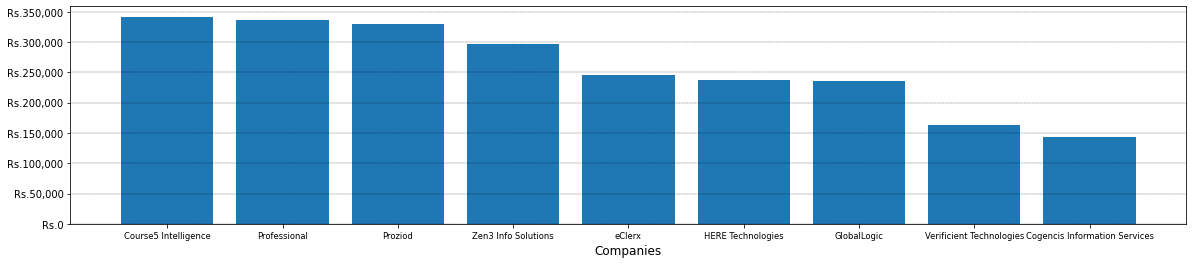

In [28]:
fig,ax = pyplot.subplots(figsize = (20,4))

ax.bar(data_analyst_comp_sr_no_outliers.sort_values(ascending = False).tail(9).index,data_analyst_comp_sr_no_outliers.sort_values(ascending = False).tail(9).values)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('Rs.{x:,.0f}'))
ax.yaxis.grid(color='black', linestyle='--', linewidth= 0.3)
ax.xaxis.set_tick_params(labelsize='small')
ax.set_xlabel('Companies',fontsize = 12)
pyplot.show()

We can see that Data Analyst Salaries are in the range of 60-80% of the salaries of Data Scientists.
This gap is expected though, as there is a lot of overlap between these two designations, and data scientist positions often have analytics near the lower rung of the vertical.

# Machine Learning Engineer
No further information needed. Steps are same as above.

In [29]:
data_mle_comp_dt = source_dt[source_dt['Job Title'] == "Machine Learning Engineer"]

data_mle_comp_dt_comp_sr = data_mle_comp_dt['Salaries Reported'].groupby(data_mle_comp_dt['Company Name']).sum().round(0)
data_mle_comp_dt_comp_sr = data_mle_comp_dt_comp_sr.sort_values(ascending = False).head(100)

big_companies = data_mle_comp_dt_comp_sr.index.tolist()
big_companies_bool = data_mle_comp_dt['Company Name'].isin(big_companies)
data_mle_comp_dt_no_outliers = data_mle_comp_dt[big_companies_bool]
data_mle_comp_dt_no_outliers.head(100)


,Company Name,Job Title,Salaries Reported,Location,Salary,Salary Value,Multipliers
3748,Quantiphi,Machine Learning Engineer,28.0,Bangalore,"₹8,75,066/yr",875066,1
3749,Tata Consultancy Services,Machine Learning Engineer,9.0,Bangalore,"₹4,90,531/yr",490531,1
3750,Accenture,Machine Learning Engineer,5.0,Bangalore,"₹7,48,712/yr",748712,1
3751,Amazon,Machine Learning Engineer,4.0,Bangalore,"₹15,25,549/yr",1525549,1
3752,Intel Corporation,Machine Learning Engineer,4.0,Bangalore,"₹52,096/mo",625152,12
...,...,...,...,...,...,...,...
4037,AppliedAICourse,Machine Learning Engineer,3.0,Hyderabad,"₹5,69,784/yr",569784,1
4038,DeepEdge,Machine Learning Engineer,3.0,Hyderabad,"₹8,80,000/yr",880000,1
4039,Amazon,Machine Learning Engineer,2.0,Hyderabad,"$85,843/yr",85843,1
4040,DONE by NONE,Machine Learning Engineer,2.0,Hyderabad,"₹68,347/mo",820164,12


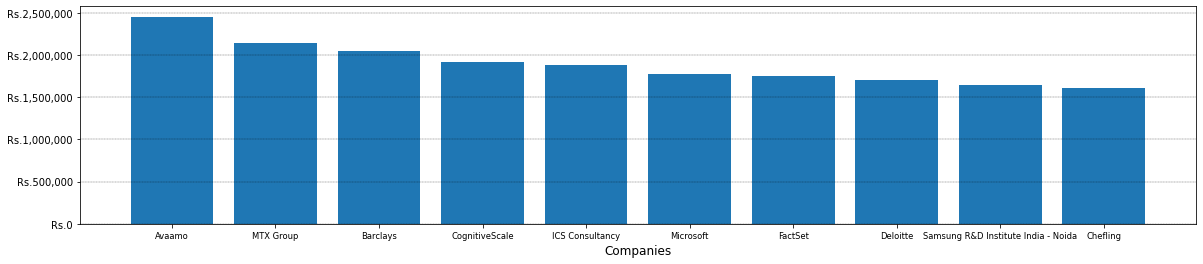

In [30]:
data_mle_comp_sr_no_outliers = data_mle_comp_dt_no_outliers['Salary Value'].groupby(data_mle_comp_dt_no_outliers['Company Name']).mean().round(0)

fig,ax = pyplot.subplots(figsize = (20,4))

ax.bar(data_mle_comp_sr_no_outliers.sort_values(ascending = False).head(10).index,data_mle_comp_sr_no_outliers.sort_values(ascending = False).head(10).values)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('Rs.{x:,.0f}'))
ax.yaxis.grid(color='black', linestyle='--', linewidth= 0.3)
ax.xaxis.set_tick_params(labelsize='small')
ax.set_xlabel('Companies',fontsize = 12)
pyplot.show()

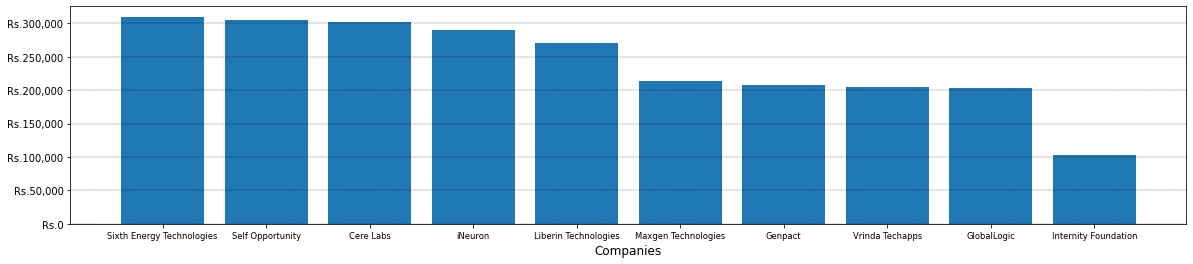

In [31]:
data_mle_comp_sr_no_outliers = data_mle_comp_dt_no_outliers['Salary Value'].groupby(data_mle_comp_dt_no_outliers['Company Name']).mean().round(0)

fig,ax = pyplot.subplots(figsize = (20,4))

ax.bar(data_mle_comp_sr_no_outliers.sort_values(ascending = False).tail(10).index,data_mle_comp_sr_no_outliers.sort_values(ascending = False).tail(10).values)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('Rs.{x:,.0f}'))
ax.yaxis.grid(color='black', linestyle='--', linewidth= 0.3)
ax.xaxis.set_tick_params(labelsize='small')
ax.set_xlabel('Companies',fontsize = 12)
pyplot.show()

MLE Salaries are comparable or lower than Data Scientist?? Whats going on? The reason is several DS roles include machine learning engineer as part of the job. DS profiles can be considered as a package of MLE + Data analytics

# Data Engineer

In [32]:
data_de_comp_dt = source_dt[source_dt['Job Title'] == "Data Engineer"]

data_de_comp_dt_comp_sr = data_de_comp_dt['Salaries Reported'].groupby(data_de_comp_dt['Company Name']).sum().round(0)
data_de_comp_dt_comp_sr = data_de_comp_dt_comp_sr.sort_values(ascending = False).head(100)

big_companies = data_de_comp_dt_comp_sr.index.tolist()
big_companies_bool = data_de_comp_dt['Company Name'].isin(big_companies)
data_de_comp_dt_no_outliers = data_de_comp_dt[big_companies_bool]
data_de_comp_dt_no_outliers.head(100)

,Company Name,Job Title,Salaries Reported,Location,Salary,Salary Value,Multipliers
2943,IBM,Data Engineer,46.0,Bangalore,"₹8,16,692/yr",816692,1
2944,Tata Consultancy Services,Data Engineer,40.0,Bangalore,"₹5,10,646/yr",510646,1
2945,LTI,Data Engineer,32.0,Bangalore,"₹4,37,609/yr",437609,1
2946,Accenture,Data Engineer,31.0,Bangalore,"₹6,54,767/yr",654767,1
2947,DXC Technology,Data Engineer,22.0,Bangalore,"₹6,26,072/yr",626072,1
...,...,...,...,...,...,...,...
3171,IBM,Data Engineer,2.0,Pune,"₹5,89,439/yr",589439,1
3181,Mastercard,Data Engineer,2.0,Pune,"₹14,99,338/yr",1499338,1
3214,Infostretch,Data Engineer,1.0,Pune,"₹11,293/mo",135516,12
3240,Dell Technologies,Data Engineer,1.0,Pune,"₹9,04,395/yr",904395,1


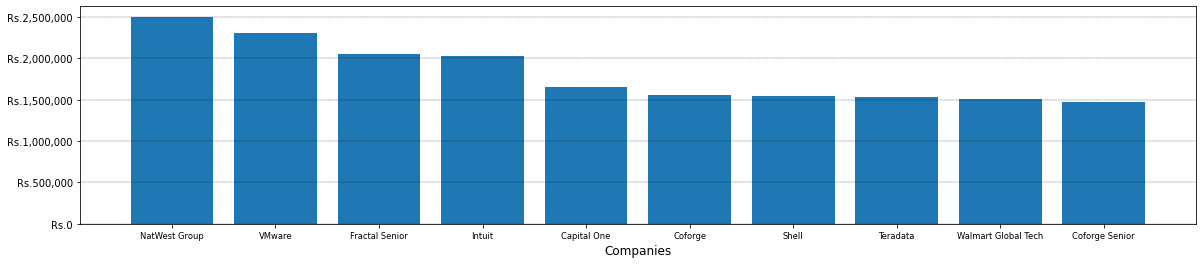

In [33]:
data_de_comp_sr_no_outliers = data_de_comp_dt_no_outliers['Salary Value'].groupby(data_de_comp_dt_no_outliers['Company Name']).mean().round(0)

fig,ax = pyplot.subplots(figsize = (20,4))

ax.bar(data_de_comp_sr_no_outliers.sort_values(ascending = False).head(10).index,data_de_comp_sr_no_outliers.sort_values(ascending = False).head(10).values)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('Rs.{x:,.0f}'))
ax.yaxis.grid(color='black', linestyle='--', linewidth= 0.3)
ax.xaxis.set_tick_params(labelsize='small')
ax.set_xlabel('Companies',fontsize = 12)
pyplot.show()

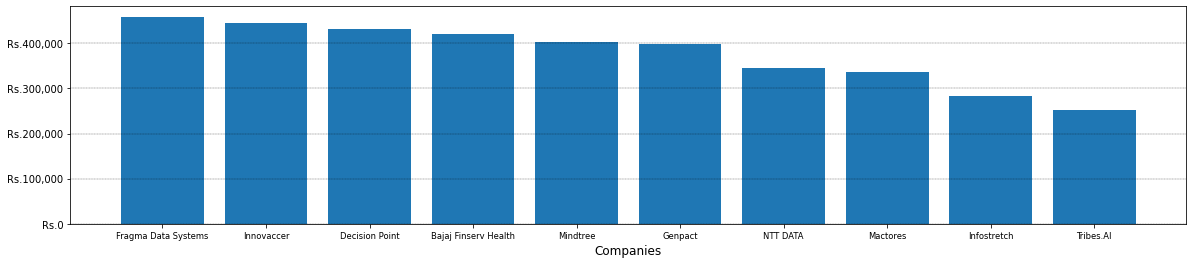

In [34]:
data_de_comp_sr_no_outliers = data_de_comp_dt_no_outliers['Salary Value'].groupby(data_de_comp_dt_no_outliers['Company Name']).mean().round(0)

fig,ax = pyplot.subplots(figsize = (20,4))

ax.bar(data_de_comp_sr_no_outliers.sort_values(ascending = False).tail(10).index,data_de_comp_sr_no_outliers.sort_values(ascending = False).tail(10).values)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('Rs.{x:,.0f}'))
ax.yaxis.grid(color='black', linestyle='--', linewidth= 0.3)
ax.xaxis.set_tick_params(labelsize='small')
ax.set_xlabel('Companies',fontsize = 12)
pyplot.show()

Data engineer salaries are lesser or comparable to Data scientists. Again its because of the more exhaustive hybrid nature of DS profiles.